# Measuring the pixel size
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

## Introduction
The pixel size is an important information of your image. It tells you the dimensions of smallest details you can expect to detect in the image and also the size of the field of view when you multiply the number of pixels in x and y by the size. 

It is also used for dimensional measurements of the objects in the images.

Finally, the pixel size is also used to scale the reconstructed attenuation coefficients. This is in particular relevant if you want to quantify the material composition of the observed objects.

All these types measurements depend on a precise value of the pixel size.

It is recommended to first work through the _Resolution introduction_ notebook before starting reading this notebook.

__Note:__ The functions in this notebook are available in a library.

### What you will learn in this tutorial
- How is the pixel size measured.
- Manual measurement.
- Using edges to measure the distance.
- An image analysis approach to measuring the pixel size.
- Error analysis

### Needed mathematical concepts
- Convolution
- Line fitting
- Distance to curve

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import tifffile as tiff
import matplotlib.patches as mpatches
import skimage.filters as flt
import sys

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf QuantifyingNeutronImages
    !git clone https://github.com/ImagingELearning/resolution.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/resolution/tutorials/00_common/data/"
    sys.path.append("/content/scripts/python")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"
    sys.path.append('../00_common/')

## The principle to measure the pixel size

The metric pixel size is the side length of the pixel in the acquired image. This quantity depends on the used optics in the imaging system and the pixel pitch on the detector.

To measure the pixel size you need an item with wellknown dimensions. The more precicely you know the dimensions the better. Ideally, you should know the distance with higher precision than the pixel size to minimize the error in the pixel size measurement. 

With such item, you count the number of pixels between two points with known distance between them.

The pixel size is then calculated as

$$\mbox{pixel size} = \frac{\mbox{Metric distance between points}}{\mbox{Number of pixels between points} }$$

In general, it best to use wide items that allows you to measure over many pixels in the image. This reduces the uncertainty in the measurement. 

The most important criterion on in the item you measure the pixel size with is that you know its dimensions. The sample opacity is of second order importance as long as you uniquely can find the edges on both sides. The item below to the left is from the IAEA neutron imaging quality assessment box that was sent to many neutron imaging stations world wide. The dark area is a 20mm x 20mm Gd sheet which actually attenuates most of the neutrons.

The best way to measure the pixel size is to use a test pattern like the one shown below to the right. It has a laser ingraved pattern which guarantees well defined feature dimensions.

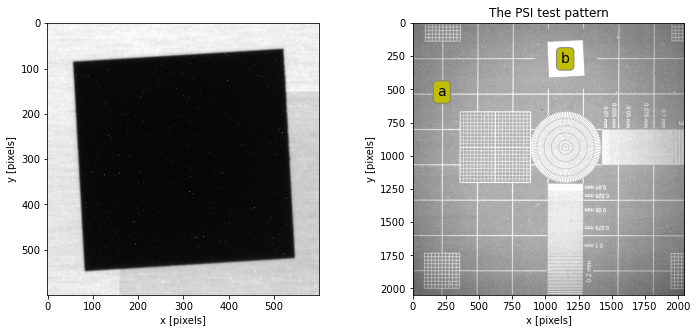

In [3]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
img1 = tiff.imread('../00_common/data/edges/edge20mm_0000.tif')
ax[0].imshow(img1,vmin=300,vmax=30000,cmap='gray');
ax[0].set_xlabel('x [pixels]')
ax[0].set_ylabel('y [pixels]');

img2 = fits.getdata('data/focus_34mm_60s.fits')
ax[1].imshow(img2,vmin=800,vmax=10000,cmap='gray')
ax[1].set_title('The PSI test pattern')
bbox_props = dict(boxstyle="round", fc="y", ec="0.5", alpha=1.0)
ax[1].text(220,520, "a", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[1].text(1150,270, "b", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[1].set_xlabel('x [pixels]')
ax[1].set_ylabel('y [pixels]');

This test pattern has two features that can be used for pixel size measurements. 

- A line grid (a) - this allows to measure over almost the full width of the image. In this case 60mm.
- A box (b) - allows to measure over a shorter distance, 10mm. The box is mainly intended for resolution measurements over an edge.

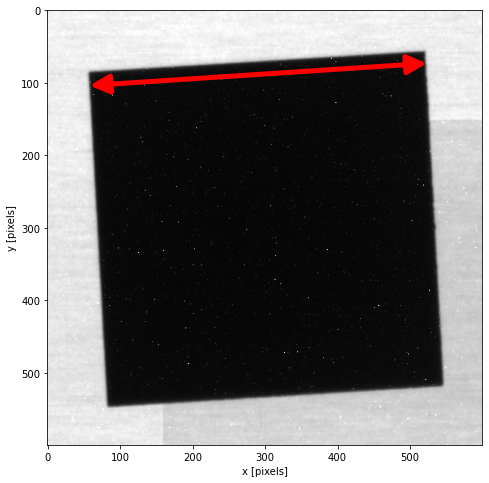

In [94]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(img1,vmin=300,vmax=30000,cmap='gray');
ax.set_xlabel('x [pixels]')
ax.set_ylabel('y [pixels]');
arrow = mpatches.FancyArrowPatch((55,104), (526, 73),
                                 mutation_scale=40,
                                 #ec='blue',fc='cornflowerblue',
                                 color='red',
                                 arrowstyle='<|-|>',linewidth=5
                                )
ax.add_patch(arrow);
#ax.annotate(text='', xy=(54,104), xytext=(527,71), arrowprops=dict(arrowstyle='<->',color='yellow',lw=4))
d=np.sqrt((528-53)**2+(104-73)**2)


In the above example we have

In [95]:
metricDistance = 20  # mm
pixelDistance  = 476 # pixels

Which gives a pixel size of 

$$\mbox{pixel size} = \frac{\mbox{Metric distance between points}}{\mbox{Number of pixels between points} }= \frac{20 \mbox{mm}}{476 \mbox{pixels}}$$

In [98]:
pixelSize = metricDistance / pixelDistance
print('The pixel size is {0:0.3f} mm'.format(pixelSize))

The pixel size is 0.042 mm


The metric distance should ideally be measured with a caliper for best precision. The pixel distance can be measured using an interactove tool like ImageJ.

Measuring the pixel size interactively is quick and convenient. But has some drawbacks:
- Only a single line is measured
- The location of the end points is arbitrary based on the perception of the person performing the measurement. 


## Towards more precise measurements
Finding edges manually is not trivial. You have to decide where does the material start and where do we see background.
 
The figure below shows a region cropped around the edge. Looking at the intensity profile near the edge we see that there are three points that could be regarde as the edge position. The best position is the mid point between the sample and background intensity.

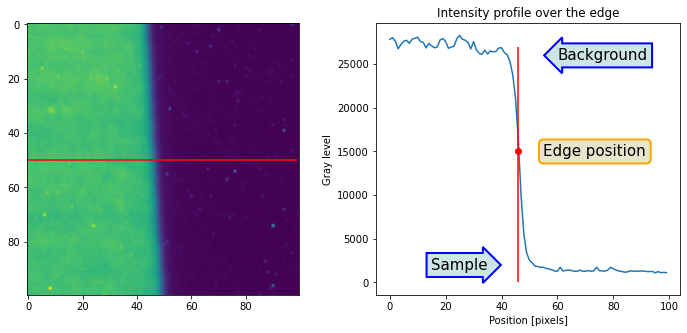

In [134]:
cimg1 = img1[200:300,20:120]

fig,axs=plt.subplots(1,2,figsize=(12,5))
axs=axs.ravel()
axs[0].imshow(cimg1)
axs[0].hlines([50],xmin=0,xmax=99,color='red')
axs[1].plot(cimg1[50,:]);
axs[1].set_title('Intensity profile over the edge')
axs[1].set_ylabel('Gray level')
axs[1].set_xlabel('Position [pixels]')
bbox_props = dict(boxstyle="larrow", fc=(0.8, 0.9, 0.9), ec="b", lw=2)
t = axs[1].text(60, 26000, "Background", ha="left", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
bbox_props = dict(boxstyle="rarrow", fc=(0.8, 0.9, 0.9), ec="b", lw=2)
t = axs[1].text(35, 2000, "Sample", ha="right", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
bbox_props = dict(boxstyle="round", fc=(0.9, 0.9, 0.8), ec="orange", lw=2)
t = axs[1].text(55, 15000, "Edge position", ha="left", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
axs[1].vlines([46],ymin=0,ymax=27000,color='red')
axs[1].plot(46,15000,'o',color='red');

Finding the mid point precisely can be hard in the image above. A handy tool is to compute the absolute gradient of the edge image and identify the local maximum. Here we use the Sobel edge detection filter which corresponds to
$$h_{Sobel}= \sqrt{{\frac{\partial img}{\partial x}}^2 + \frac{\partial img}{\partial y}^2} $$
The operator is provided in sci kit image.

In [166]:
gimg1=flt.sobel(cimg1)

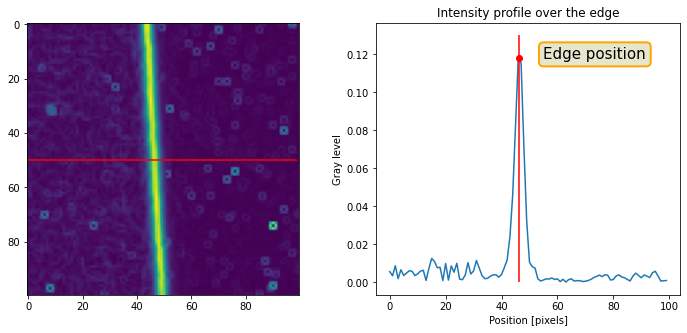

In [167]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
axs=axs.ravel()
axs[0].imshow(gimg1)
axs[0].hlines([50],xmin=0,xmax=99,color='red')
axs[1].plot(gimg1[50,:]);
axs[1].set_title('Intensity profile over the edge')
axs[1].set_ylabel('Gray level')
axs[1].set_xlabel('Position [pixels]')

bbox_props = dict(boxstyle="round", fc=(0.9, 0.9, 0.8), ec="orange", lw=2)
t = axs[1].text(55, 0.12, "Edge position", ha="left", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
axs[1].vlines([46.2],ymin=0,ymax=0.13,color='red')
axs[1].plot(46.2,0.118,'o',color='red');

The edge position can be found using different methods:
- Find the position of the max gradient value
- Compute the center of gravity of the profile
- Fit an edge spread function to the profile

Let's compute the center of gravity:

$$COG = \frac{\sum_{i=1}^N p_i\cdot x_i}{\sum_{i=1}^N p_i}$$

In [150]:
p = gimg1[50,:]        # extract a profile
p[p<0.02]=0            # removing values below 0.02 to avoid including noise contributions.

# Compute center of gravity
x = np.linspace(0,99,100)
cog = (p*x).sum()/p.sum()

# result
print('The edge is located at {0:0.1f}'.format(cog))

The edge is located at 46.2


## Measure the distance using image analysis (advanced topic)
### Fit a line to the edge
The analysis relative to the edge position depends on fitting a model for the edge line. This information is useful both in this tutorial and also in the resolution tutorial.

__Note:__ This is an advanced section that requires some more image processing, coding, and math. You can [skip this part](#example_pixel_size) and use the provided functions in the tutorial library.

In [206]:
[x,y]=np.meshgrid(np.linspace(0,gimg1.shape[0]-1,gimg1.shape[0]),
                  np.linspace(0,gimg1.shape[1]-1,gimg1.shape[1]))

pimg = gimg1
pimg[pimg<0.08]=0
cog = (x*pimg).sum(axis=1)/pimg.sum(axis=1)
pos = np.arange(len(cog))

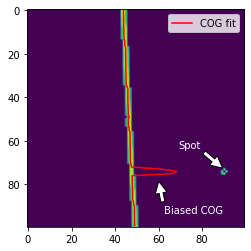

In [201]:
plt.imshow(gimg1)
plt.plot(cog,pos,color='red',label='COG fit')
plt.annotate('Spot', xy=(90, 73),  xycoords='data',
            xytext=(0.8, 0.4), textcoords='axes fraction',color='white',
            arrowprops=dict(facecolor='white', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Biased COG', xy=(60, 78),  xycoords='data',
            xytext=(0.9, 0.1), textcoords='axes fraction',color='white',
            arrowprops=dict(facecolor='white', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',)

plt.legend();

The gamma spots in the radiograph introduces biases in the COG. The line fit to the edge will be not be as exact as needed if the outliers are included.

In [225]:
line=np.polyfit(pos,cog,1)
print(line)

[ 0.07023216 43.3808072 ]


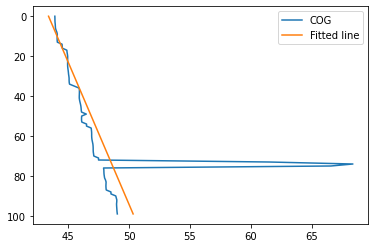

In [226]:
#plt.imshow(gimg1)
fig,ax=plt.subplots(1)
ax.plot(cog,pos,label='COG')
ax.plot(line[1]+line[0]*pos,pos,label='Fitted line')
ax.invert_yaxis()
# plt.annotate('Spot', xy=(90, 73),  xycoords='data',
#             xytext=(0.8, 0.4), textcoords='axes fraction',color='white',
#             arrowprops=dict(facecolor='white', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             )
# plt.annotate('Biased COG', xy=(60, 78),  xycoords='data',
#             xytext=(0.9, 0.1), textcoords='axes fraction',color='white',
#             arrowprops=dict(facecolor='white', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',)

plt.legend();


You can reduce the impact of outliers by applying a spot removal filter before computing the gradient image. In this tutorial, we use a different approach by selecting the central quantile of the COG.

In [230]:
idx=np.argsort(cog) # indirect sorting, returns a vector with indices of the sorting 
N=5
line2=np.polyfit(pos[idx[N:-N]],cog[idx[N:-N]],1) # exclude N most deviating points at beginning and end 
print(line2)

[ 0.05503879 43.5867871 ]


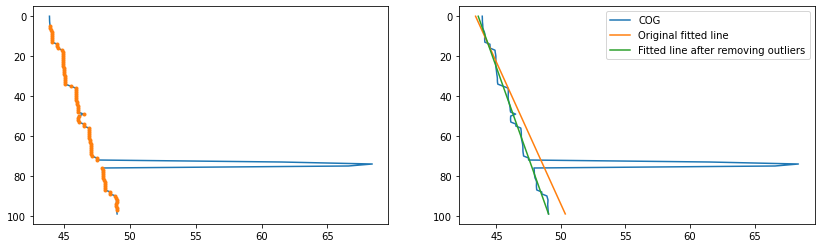

In [229]:
fig,ax=plt.subplots(1,2,figsize=(14,4))
ax[0].plot(cog,pos)
ax[0].plot(cog[idx[N:-N]],pos[idx[N:-N]],'.')
ax[0].invert_yaxis()

ax[1].plot(cog,pos,label='COG')
ax[1].plot(line[1] + line[0]  * pos, pos,label='Original fitted line')
ax[1].plot(line2[1]+ line2[0] * pos, pos,label='Fitted line after removing outliers')
ax[1].invert_yaxis()
ax[1].legend();

### Locate the edges

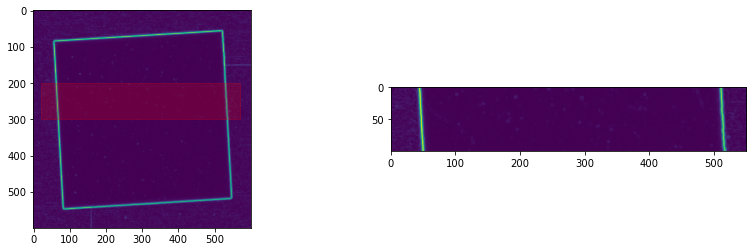

In [249]:
gimg = flt.sobel(flt.median(img1)) # we use a median filter here to reduce the outliers

cimg = gimg[200:300,20:570]
profile = cimg.mean(axis=1)
fig,ax = plt.subplots(1,2,figsize=(14,4))
ax=ax.ravel()
ax[0].imshow(gimg)
rect=mpatches.Rectangle((20,200),550,100,fc='r',ec='r',alpha=0.2)
ax[0].add_patch(rect)
ax[1].imshow(cimg);

### Compute the COG for each edge

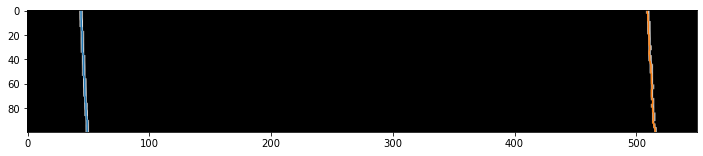

In [266]:
def COG(gimg1,begin,end) :
    [x,y]=np.meshgrid(np.linspace(0,gimg1.shape[1]-1,gimg1.shape[1]),
                  np.linspace(0,gimg1.shape[0]-1,gimg1.shape[0]))

    pimg = gimg1
    th=(pimg.max()-pimg.min())*0.3+pimg.min()
    pimg[pimg<th]=0
    cog = (x[:,begin:end]*pimg[:,begin:end]).sum(axis=1)/pimg[:,begin:end].sum(axis=1)
    pos = np.arange(len(cog))
    return cog,pos

cog_left,pos_left   = COG(cimg,0,100)
cog_right,pos_right = COG(cimg,450,570)
fig,ax=plt.subplots(1,figsize=(12,5))
plt.imshow(cimg,cmap='gray')
plt.plot(cog_left,pos_left)
plt.plot(cog_right,pos_right);

In [304]:
def fitEdgeLine(cog,N) :
    idx=np.argsort(cog) # indirect sorting, returns a vector with indices of the sorting 
    line=np.polyfit(pos[idx[N:-N]],cog[idx[N:-N]],1) # exclude N most deviating points at beginning and end 
    return line 

line_left = fitEdgeLine(cog, N=5)
print(line_left)

[ 0.05503879 43.5867871 ]


### Measure the distance between two lines
The first step to measure the distance between two lines is to find them. We will use the line fit of one edge and measure the perpendicular distance between the COGs points from the second edge. 

1. Locate the two edges
2. Compute the COG vectors for each edge
3. Fit the COG of one edge
4. Compute the distance
For
$A x + B y +C = 0$
the signed distance is
$d(m,n)=\frac{A m + B n + C}{\sqrt{A^2+B^2}}$

B=-1

In [283]:
def pointDistance(coefs,r,c) :
    d=-(r*coefs[0]-c+coefs[1])/np.sqrt(coefs[0]**2+1.0)
    
    return d
    
def computeDistanceField(coefs,size) :
    r,c=np.meshgrid(np.arange(0,size[1]), np.arange(0,size[0]))
    
    d=-(c*coefs[0]-r+coefs[1])/np.sqrt(coefs[0]**2+1.0)
    
    return d

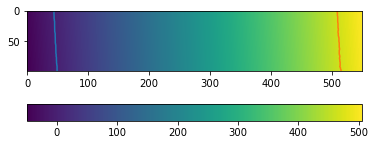

In [288]:
dist=computeDistanceField(line_left,cimg.shape)
plt.imshow(dist)
plt.plot(cog_left,pos_left)
plt.plot(cog_right,pos_right);
plt.colorbar(orientation = 'horizontal');

In [287]:
d = pointDistance(line_left,0,cog_right[0]) 
print('The distance between the left edge and the first point on the right is {0:0.2f} pixels'.format(d))

The distance between the left edge and the first point on the right is 464.79 pixels


In [315]:
d = pointDistance(line_left,pos_right,cog_right)
m=d.mean()
s=d.std()
print('Average distance m={0:0.2f} s={1:0.2f}'.format(m,s))

Average distance m=464.89 s=0.32


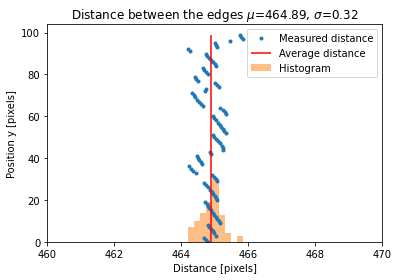

In [311]:
plt.plot(d,pos_right,'.',label='Measured distance')
plt.xlim([460,470])
plt.vlines([m],ymin=pos_right.min(),ymax=pos_right.max(),color='r',label='Average distance')
plt.xlabel("Distance [pixels]")
plt.ylabel("Position y [pixels]")
plt.title('Distance between the edges $\mu$={0:0.2f}, $\sigma$={1:0.2f}'.format(m,s))
#plt.gca().invert_yaxis()
plt.hist(d,bins=9,label='Histogram',alpha=0.5)
plt.legend();


The advantage of using this method is that you also get a estimate of the error

## Pixel size from the example

<a id='example_pixel_size'></a>

The object in our image example was measured using a caliper to the dimension 20.0 +/-0.05 mm and the image analysis gave us the number of pixels between two edges to be 464.9 +/-0.32 pixels. This information lets us compute the pixel size. 

In [321]:
length       = 20.0 # mm
error_length = 0.05 # mm
pixels       = 464.9 # pixels
error_pixels = 0.32  # pixels

pixel_size = length/pixels

print('The measured pixel size is {0:0.3f} mm/pixel'.format(pixel_size))

The measured pixel size is 0.043 mm/pixel


### Error analysis

Every measurement has an uncertainty. In our case it is the accuracy of the caliper used to measure the dimensions of the test object and how well we could count the number of pixels between the two edges.

The error in manual measurments is at least a pixel, but is mostly more due to the uncertainty in selecting the positions of the measurement line. With the automated analysis, it should be possible to have errors of less than a pixel.

You can read more about error analysis in [this tutorial](https://www.webassign.net/question_assets/unccolphysmechl1/measurements/manual.html).

The error of $a/b$ is defined as
$$\frac{\sigma_{Pixelsize}}{Pixelsize}=\sqrt{({\frac{\sigma_{pixels}}{pixels} })^2+ ({\frac{\sigma_{length}}{length}})^2}$$
which we will use below.

In [325]:
rel_uncertainty = np.sqrt((error_pixels/pixels)**2 + (error_length/length)**2)

print('Pixel size = {0:0.3f} mm/pixel +/- {1:0.4f} %'.format(pixel_size,rel_uncertainty*100))

Pixel size = 0.043 mm/pixel +/- 0.2593 %


From this equation it becomes clear that shorter test objects will result in greater errors in the pixel size as it is hard to improve the accuracy of the measured quantities. 

## Summary
- The pixel size is needed for more than dimensional measurements. 
    - The attenuation coefficient of the tomography voxels scales with the pixel size.
    - The pixel size is also needed to measure the resolution of the imaging system.
- Measuring the pixel size requires a sample with known dimensions and to measure how many pixels this corresponds to.
- The pixel width can be measured manually or automated. The latter is more precise.
- It is possible to obtain a measurement error. 